##### 建立並串接 Webhook
已經建立了 LINE BOT 的 Channel 之後，下一步就是要將 LINE BOT 串接 Webhook，讓 LINE 聊天的訊息能夠透過 Webhook 傳遞到用 Python 編輯的程式去做處理，\
這篇教學將會介紹如何產生 Webhook，以及如何串接 Webhook。

##### 什麼是 Webhook？ 
Webhook 指的是一個「網址」，透過伺服器建立 Webhook 網址後，有串接 Webhook 的位置就能使用 HTTP 的 POST 方法，向伺服器傳送或接收特定的資料。

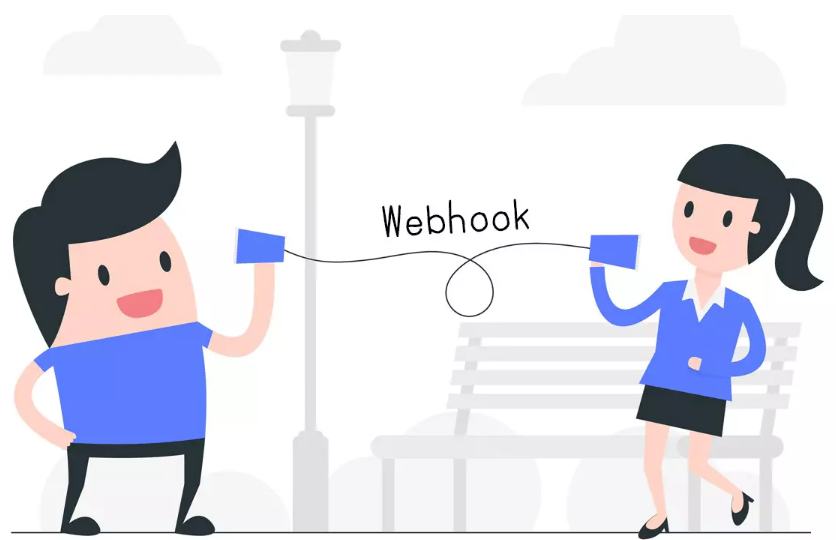

##### LINE BOT 與 WebHook 的關係 
當使用者在 LINE 聊天室裡跟 LINE BOT 聊天，會發生下列的步驟：

* Step 1：向使用 Message API 所建立的 LINE BOT 發送訊息。
* Step 2：訊息透過 Webhook 傳遞到使用者部署 Python 程式的伺服器。
* Step 3：根據 Python 程式的邏輯，處理訊息。
* Step 4：透過 Webhook 回傳結果到 LINE BOT。
* Step 5：LINE BOT 發送訊息到 LINE 聊天室裡。

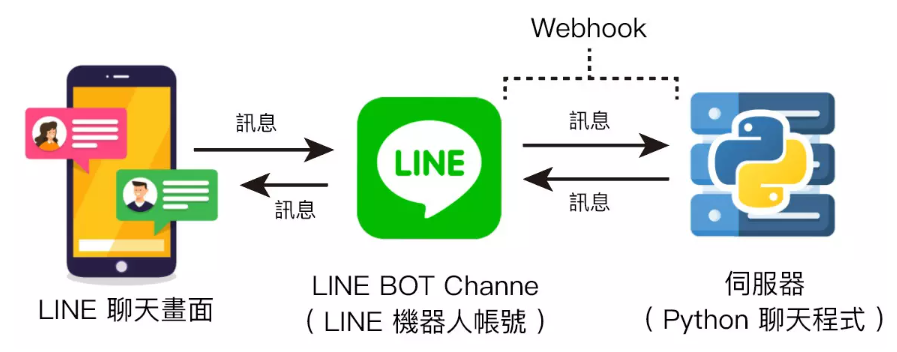

##### 取得 LINE Channel access token 和 Channel secret 
延伸「建立 LINE Channel」文章，進入自己建立的 LINE Channel，前往 Basic settings 頁籤，能夠看到 Channel secret\
( 如果沒有看到或需要重新產生，點擊 Reissue 就能產生 )。

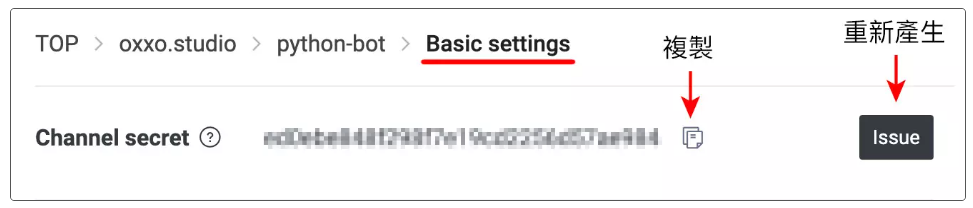

前往 Messaging API 頁籤，可以看到 Channel access token，它和 Channel secret 都是串接 LINE Channel 必須的金鑰\
( 如果沒有看到或需要重新產生，點擊 Reissue 就能產生 )。

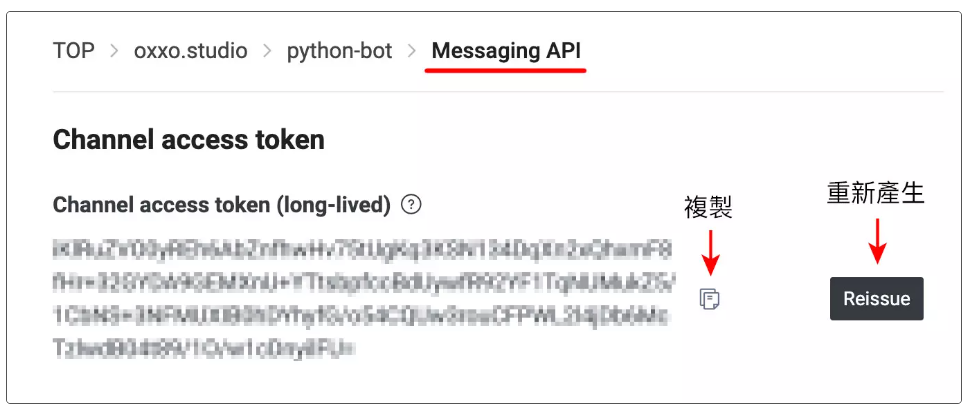

##### 使用 ngrok + 本機環境建立 Webhook 
參考 LINE 官方所提供的 Python 開發文件：LINE Messaging API SDK for Python，輸入下方的程式碼，安裝 LINE BOT 函式庫。

* pip install line-bot-sdk

完成後，執行下方的程式碼就會在本機環境建立伺服器。

In [ ]:
from flask import Flask, request

# 載入 json 標準函式庫，處理回傳的資料格式
import json

# 載入 LINE Message API 相關函式庫
from linebot import LineBotApi, WebhookHandler
from linebot.exceptions import InvalidSignatureError
from linebot.models import MessageEvent, TextMessage, TextSendMessage

app = Flask(__name__)

@app.route("/", methods=['POST'])
def linebot():
    body = request.get_data(as_text=True)                    # 取得收到的訊息內容
    try:
        json_data = json.loads(body)                         # json 格式化訊息內容
        access_token = ''
        secret = ''
        line_bot_api = LineBotApi(access_token)              # 確認 token 是否正確
        handler = WebhookHandler(secret)                     # 確認 secret 是否正確
        signature = request.headers['X-Line-Signature']      # 加入回傳的 headers
        handler.handle(body, signature)                      # 綁定訊息回傳的相關資訊
        tk = json_data['events'][0]['replyToken']            # 取得回傳訊息的 Token
        type = json_data['events'][0]['message']['type']     # 取得 LINe 收到的訊息類型
        if type=='text':
            msg = json_data['events'][0]['message']['text']  # 取得 LINE 收到的文字訊息
            print(msg)                                       # 印出內容
            reply = msg
        else:
            reply = '你傳的不是文字呦～'
        print(reply)
        line_bot_api.reply_message(tk,TextSendMessage(reply))# 回傳訊息
    except:
        print(body)                                          # 如果發生錯誤，印出收到的內容
    return 'OK'                                              # 驗證 Webhook 使用，不能省略

if __name__ == "__main__":
    app.run()

參考「使用 ngrok 服務」和「本機環境使用 ngrok」的文章內容，註冊 ngrok 服務並取得 token，並在終端機裡輸入下列指令，\
將本機伺服器網址指向 ngrok 網址 ( port 預設都是填入 5000 )

* ngrok http 127.0.0.1:5000

完成後，就會看到終端機裡出現 ngrok 的公開網址 ( 每次重新執行後，網址都會改變 )

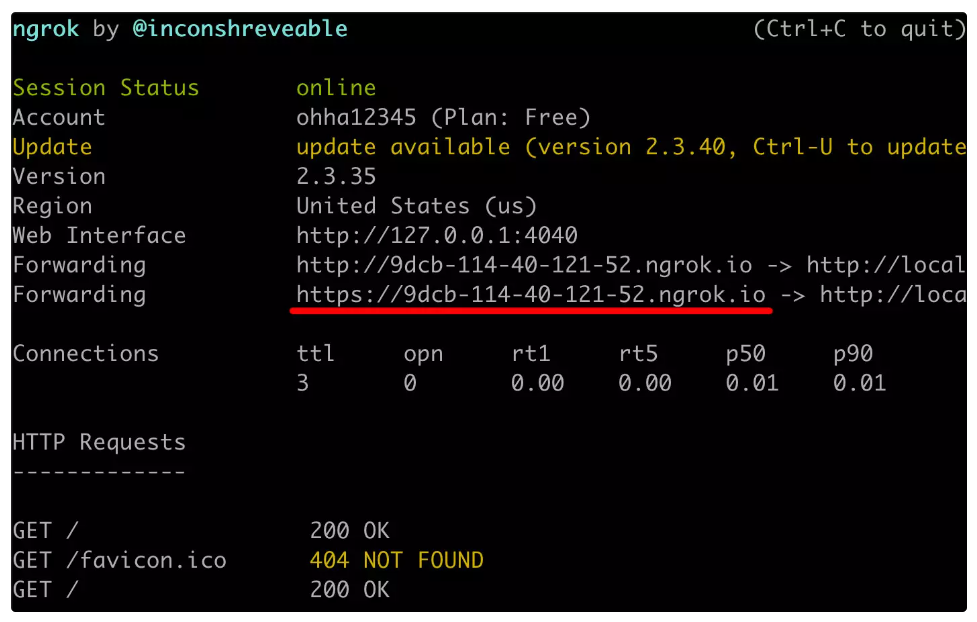

複製這串網址後，前往「LINE Developer 控制台」，進入自己建立的 LINE BOT Channel ( 參考：建立 LINE Channel )，\
在 Message API 頁籤裡找到 Webhook setting 選項，貼上 ngrok 網址 ( 注意要使用 https )。

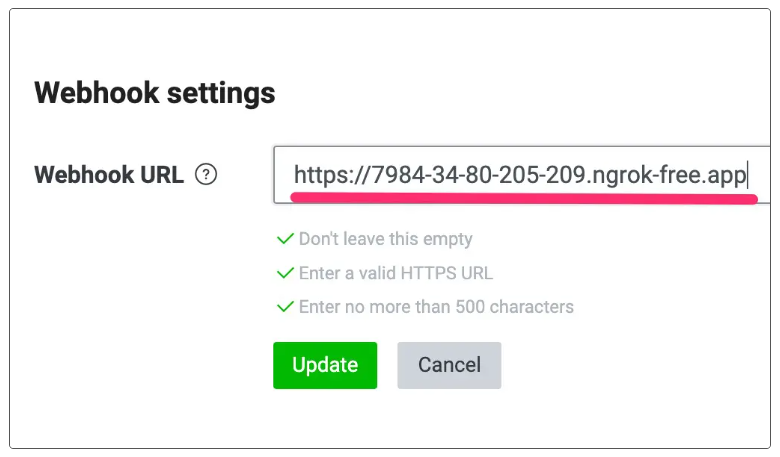

完成後，點擊「Verify」進行驗證，如果出現 Success 文字表示已經可以正常串接。

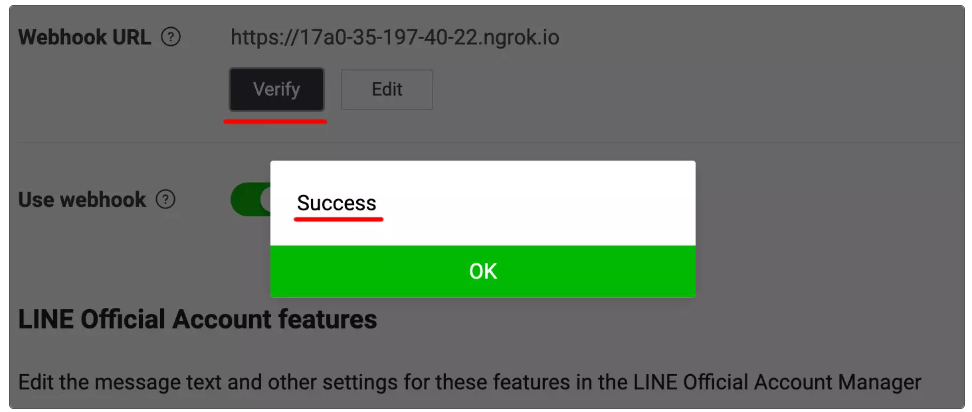

開啟 LINE，找到 LINE BOT 的帳號，傳送訊息給 LINE BOT，LINE BOT 就會回應相同的訊息。

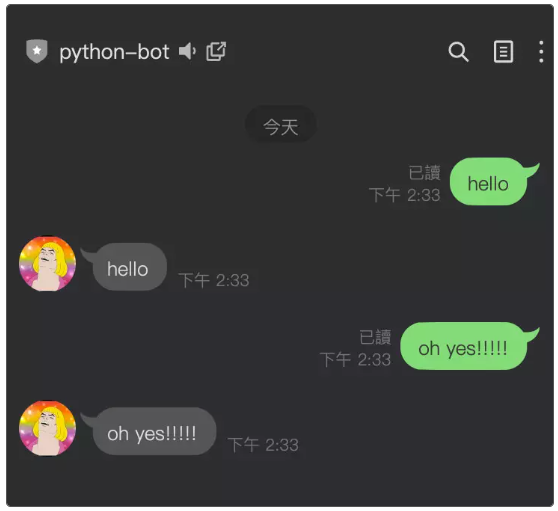

##### 使用 ngrok + Colab 建立 Webhook 
參考「使用 ngrok 服務」和「Google Colab 使用 ngrok」的文章內容，註冊 ngrok 服務並取得 token 並在 Colab 裡安裝 ngrok，\
完成後參考 LINE 官方所提供的 Python 開發文件：LINE Messaging API SDK for Python，在 Colab 裡輸入下方的程式碼。

In [ ]:
from flask import Flask, request
from pyngrok import ngrok


# 載入 LINE Message API 相關函式庫
from linebot import LineBotApi, WebhookHandler
from linebot.exceptions import InvalidSignatureError
from linebot.models import MessageEvent, TextMessage, TextSendMessage

import json

app = Flask(__name__)
port = "5000"

# Open a ngrok tunnel to the HTTP server
public_url = ngrok.connect(port).public_url
print(f" * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:{port}\" ")

@app.route("/", methods=['POST'])
def linebot():
    body = request.get_data(as_text=True)                    # 取得收到的訊息內容
    try:
        json_data = json.loads(body)                         # json 格式化訊息內容
        access_token = '你的 access token'
        secret = '你的 Channel secret'
        line_bot_api = LineBotApi(access_token)              # 確認 token 是否正確
        handler = WebhookHandler(secret)                     # 確認 secret 是否正確
        signature = request.headers['X-Line-Signature']      # 加入回傳的 headers
        handler.handle(body, signature)                      # 綁定訊息回傳的相關資訊
        msg = json_data['events'][0]['message']['text']      # 取得 LINE 收到的文字訊息
        tk = json_data['events'][0]['replyToken']            # 取得回傳訊息的 Token
        line_bot_api.reply_message(tk,TextSendMessage(msg))  # 回傳訊息
        print(msg, tk)                                       # 印出內容
    except:
        print(body)                                          # 如果發生錯誤，印出收到的內容
    return 'OK'                 # 驗證 Webhook 使用，不能省略
if __name__ == "__main__":
  app.run()

點擊 Colab 的執行按鈕，就會得到一串 ngrok 對應的網址，這串網址就是要與 LINE BOT 串接的 Webhook。

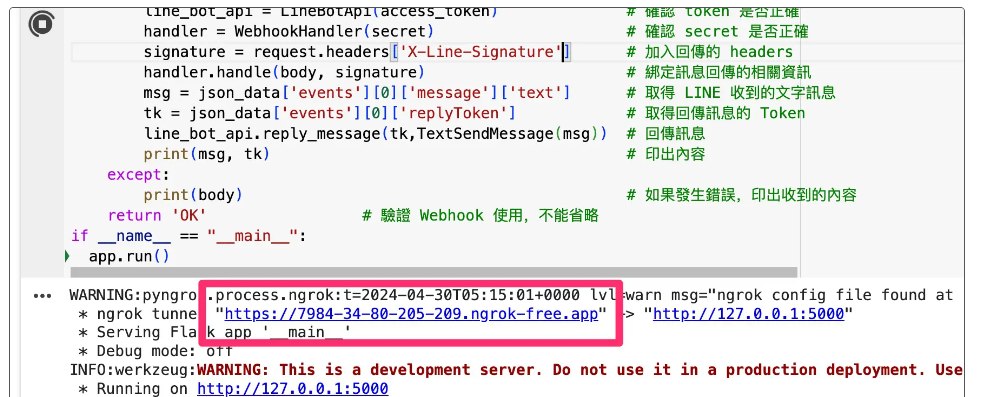

複製這串網址後，前往「LINE Developer 控制台」，進入自己建立的 LINE BOT Channel ( 參考：建立 LINE Channel )，\
在 Message API 頁籤裡找到 Webhook setting 選項，貼上剛剛透過 ngrok 產生的 webhook 網址。

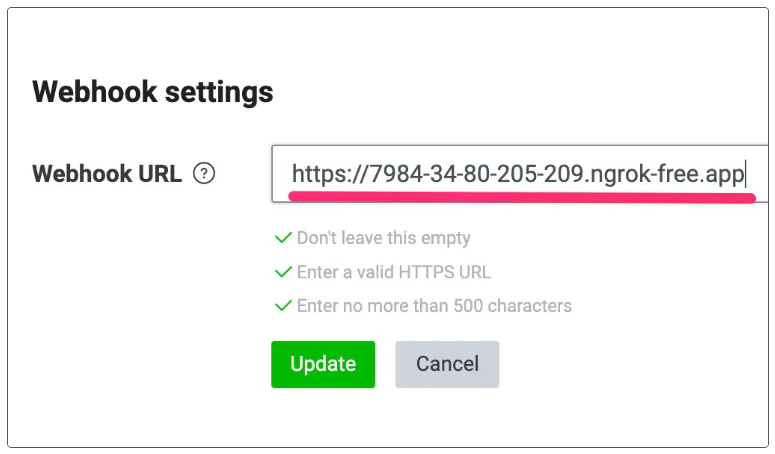

完成後，點擊「Verify」進行驗證，如果出現 Success 文字表示已經可以正常串接。

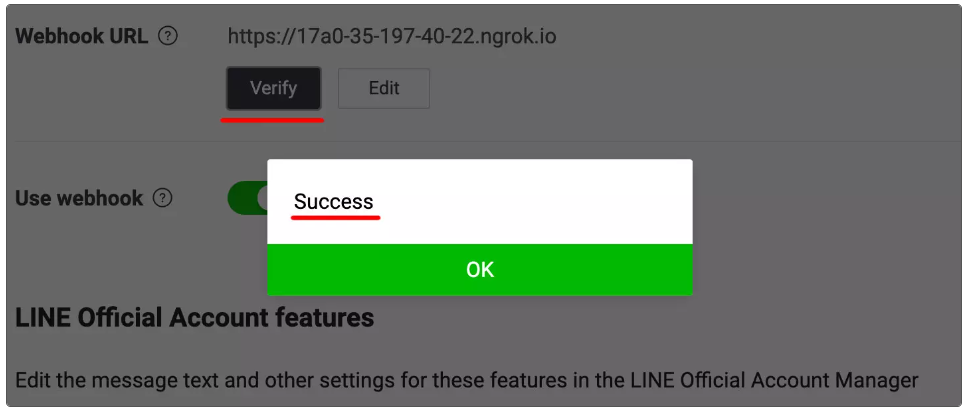

開啟 LINE，找到 LINE BOT 的帳號，傳送訊息給 LINE BOT，LINE BOT 就會回應相同的訊息。

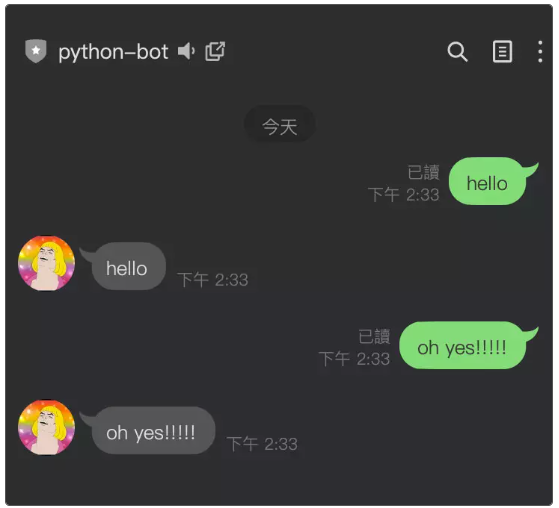

##### 使用 Cloud Functions 建立 Webhook 
由於使用 Colab + ngrok 所建置的 Webhook，會受限於 Colab 只能運行幾個小時，以及 ngrok 在每次部署都會改變網址的特性，\
所以無法當作正式的 LINE BOT Webhook ( Colab 閒置超過一段時間後還會停止執行並清除安裝的函式庫，需要再次重新安裝 )。

如果要建立一個可以 24 小時不斷運作的 LINE BOT，就可以選擇 Google Cloud Functions 作為 Python 運作的後台，\
參考「使用 Google Cloud Functions」文章，新增並啟用一個 Cloud Functions 程式編輯環境，環境的執行階段選擇 Python ( 3.7～3.9 皆可 )，\
進入點改成 linebot ( 可自訂名稱，之後的程式碼裡也要使用同樣的名稱 )。

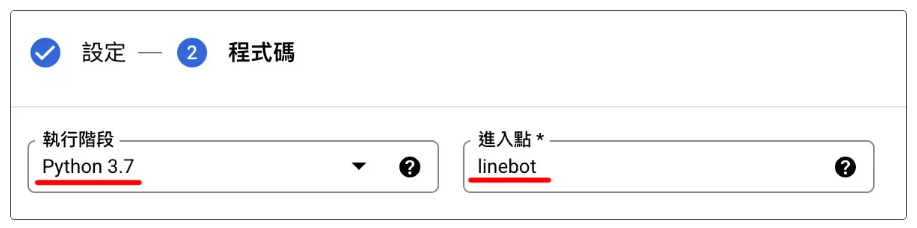

建立編輯環境後，點擊 requirements.txt，加入 line-bot-sdk ( requirements.txt 的作用是 Cloud Functions 啟用程式時需要安裝的外部函式庫 )

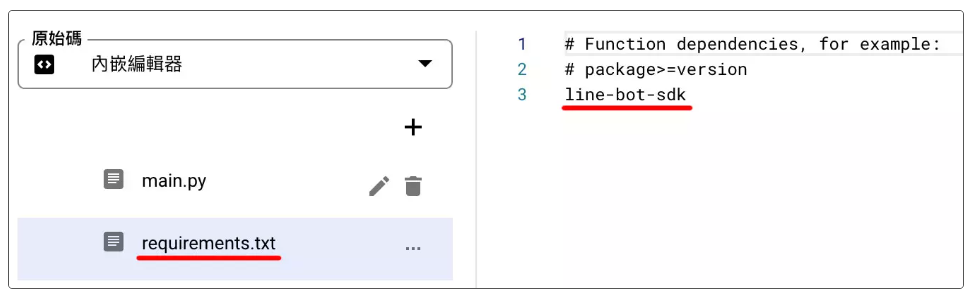

點擊 main.py，輸入下方程式碼 ( 因為 Clouds Functions 的 Python 樣板是以 Flask 的基礎建立，所以不需要額外安裝 Flask )

In [ ]:
import json
from linebot import LineBotApi, WebhookHandler
from linebot.exceptions import InvalidSignatureError
from linebot.models import MessageEvent, TextMessage, TextSendMessage

def linebot(request):
    try:
        access_token = '你的 LINE Channel access token'
        secret = '你的 LINE Channel secret'
        body = request.get_data(as_text=True)
        json_data = json.loads(body)
        line_bot_api = LineBotApi(access_token)
        handler = WebhookHandler(secret)
        signature = request.headers['X-Line-Signature']
        handler.handle(body, signature)
        msg = json_data['events'][0]['message']['text']
        tk = json_data['events'][0]['replyToken']
        line_bot_api.reply_message(tk,TextSendMessage(msg))
        print(msg, tk)
    except:
        print(request.args)
    return 'OK'

完成後，點擊部署，完成後會看見出現綠色打勾的圖示。

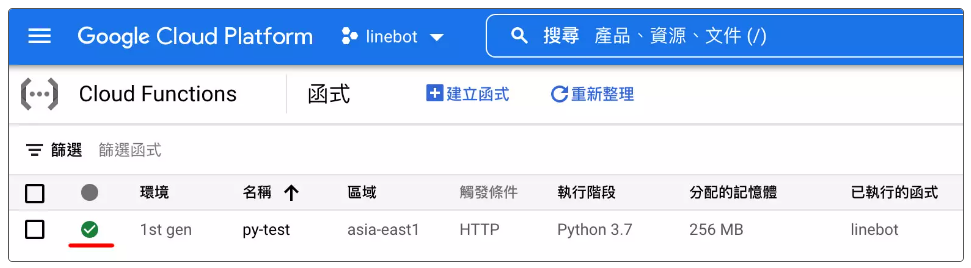

點擊進入程式，選擇「觸發條件」，複製觸發網址 ( 這串網址就是要與 LINE BOT 串接的 Webhook )。

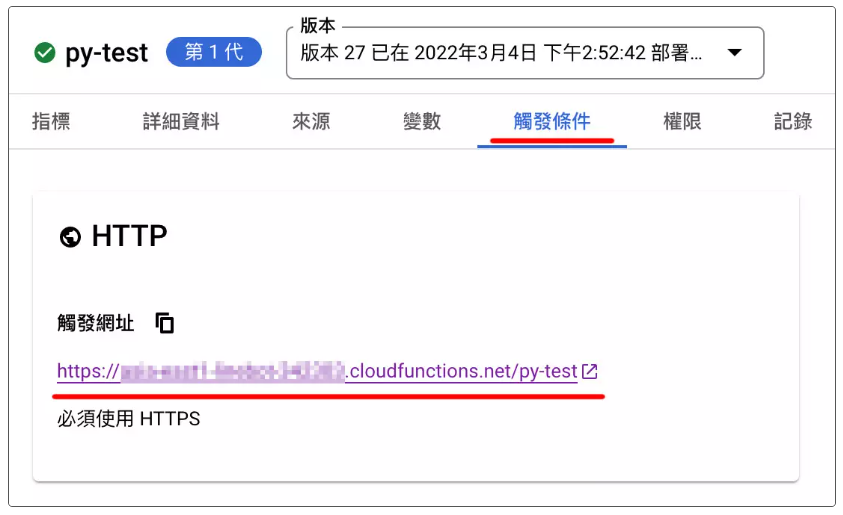

前往「LINE Developer 控制台」，進入自己建立的 LINE BOT Channel ( 參考：建立 LINE Channel )，在 Message API 頁籤裡找到 Webhook setting 選項，貼上網址。

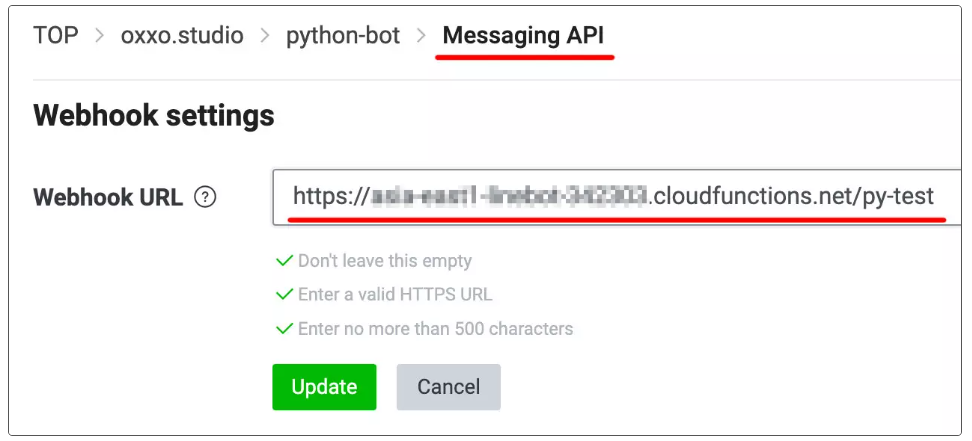

完成後，點擊「Verify」進行驗證，如果出現 Success 文字表示已經可以正常串接。

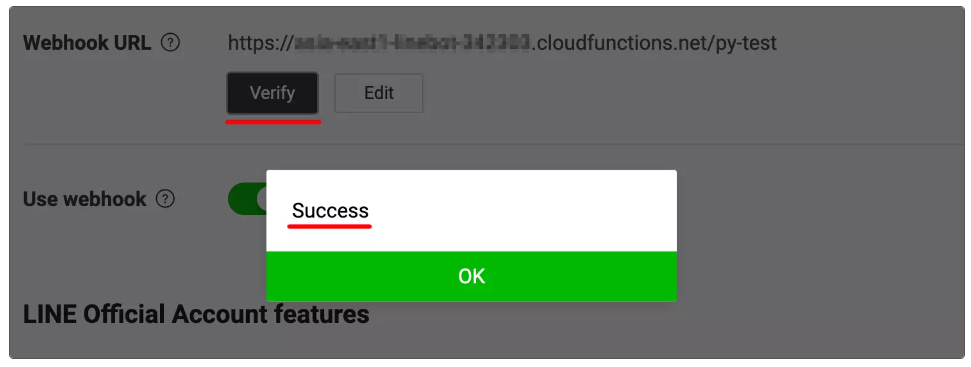

開啟 LINE，找到 LINE BOT 的帳號，傳送訊息給 LINE BOT，LINE BOT 就會回應相同的訊息。

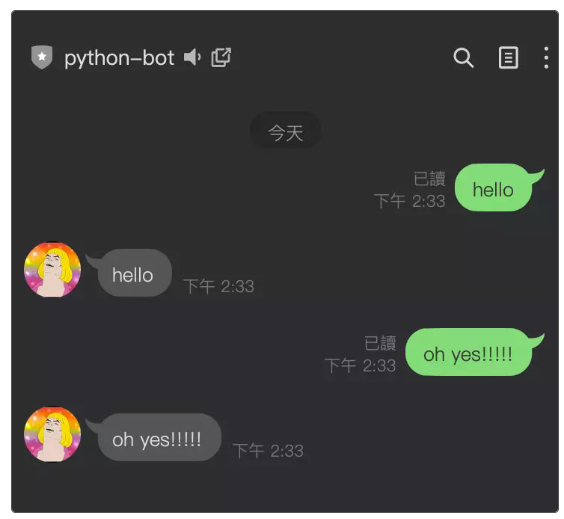

##### 小結 
到這個步驟，應該已經建立了一個最基本的 LINE BOT ( 可以發送訊息給 LINE BOT，且 LINE BOT 也會回應同樣的訊息 )，\
接下來會繼續介紹更多 LINE BOT 的傳訊息方法，以及主動推播訊息的功能。